In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,ZeroPadding2D, BatchNormalization, Activation, Layer, ReLU, LeakyReLU,Conv2D,AveragePooling2D,UpSampling2D,Reshape,Flatten
from tensorflow.keras import backend as K

In [2]:
from func import load_model, save_model

## Load dataset

In [3]:
filename = 'BKG_dataset.h5'

In [19]:
# make sure input data has correct input shape - background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

In [20]:
X_train = np.reshape(X_train, (-1, 19,3,1))
X_test = np.reshape(X_test, (-1, 19,3,1))
X_val = np.reshape(X_val, (-1, 19,3,1))

## Define Dense NN architecture

In [21]:
image_shape = (19,3,1)
latent_dimension = 8
num_nodes=[16,8]

In [22]:
#encoder
input_encoder = Input(shape=(image_shape))
x = Conv2D(10, kernel_size=(3, 3),
         use_bias=False, data_format='channels_last', padding='same')(input_encoder)
x = AveragePooling2D(pool_size = (2, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(latent_dimension)(x)
enc = Activation('relu')(x)
encoder = Model(inputs=input_encoder, outputs=enc)
#decoder
x = Dense(270)(enc)
x = Activation('relu')(x)
x = Reshape((9,3,10))(x)
x = UpSampling2D((2, 1))(x)
x = ZeroPadding2D(((1, 0),(0,0)))(x)
x = Conv2D(1, kernel_size=(3,3), use_bias=False, data_format='channels_last', padding='same')(x)
x = BatchNormalization()(x)
dec = Activation('relu')(x)

autoencoder = Model(inputs=input_encoder, outputs=dec)
autoencoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 19, 3, 1)]        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 3, 10)         90        
_________________________________________________________________
average_pooling2d_3 (Average (None, 9, 3, 10)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 3, 10)          40        
_________________________________________________________________
activation_11 (Activation)   (None, 9, 3, 10)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 270)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)               

In [23]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Train model

In [24]:
EPOCHS = 100
BATCH_SIZE = 1024

In [25]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/100
625/625 [==============================] - 18s 29ms/step - loss: 64.0750 - val_loss: 55.4394
Epoch 2/100
625/625 [==============================] - 18s 28ms/step - loss: 52.0528 - val_loss: 45.4417
Epoch 3/100
625/625 [==============================] - 19s 31ms/step - loss: 43.2803 - val_loss: 37.7284
Epoch 4/100
625/625 [==============================] - 20s 32ms/step - loss: 35.9256 - val_loss: 31.1201
Epoch 5/100
625/625 [==============================] - 17s 27ms/step - loss: 29.5631 - val_loss: 25.3136
Epoch 6/100
625/625 [==============================] - 17s 27ms/step - loss: 24.0011 - val_loss: 20.3397
Epoch 7/100
625/625 [==============================] - 17s 27ms/step - loss: 19.1423 - val_loss: 15.9734
Epoch 8/100
625/625 [==============================] - 17s 27ms/step - loss: 14.9645 - val_loss: 12.2635
Epoch 9/100
625/625 [==============================] - 17s 27ms/step - loss: 11.3833 - val_loss: 9.4111
Epoch 10/100
625/625 [==============================] - 

In [ ]:
model_name = 'model_name'
model_directory = ''
save_model(model_directory+model_name, autoencoder)

In [26]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

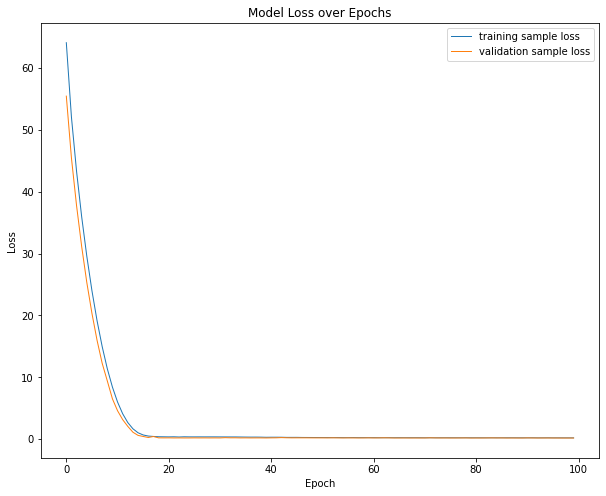

In [27]:
learningCurve(history)


## Prediction - background

In [48]:
bkg_prediction = autoencoder.predict(X_test)

In [49]:
np.save('bkgprediction',bkg_prediction)

## Prediction - signals

In [50]:
signal_labels = ['Particles', 'Particles','Particles','Particles']

In [51]:
signals_file = ['Ato4l_lepFilter_13TeV.h5', 'hChToTauNu_13TeV_PU20.h5', 'hToTauTau_13TeV_PU20.h5','leptoquark_LOWMASS_lepFilter_13TeV.h5' ]

In [60]:
# add correct path to signal files
signal_data = []
for i, label in enumerate(signal_labels, ):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
        test_data = test_data[:,:,0:3]
        test_data = np.reshape(test_data,(test_data.shape[0],57) )
    signal_data.append(test_data)

In [61]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(np.reshape(signal_data[i],(-1, 19,3,1)))
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

In [134]:
signal_prediction = signal_prediction.reshape(-1,57)

In [135]:
signal_prediction.shape

(340544, 57)

## Save results

In [68]:
signal_prediction.shape

(340544, 19, 3, 1)

In [67]:
save_file = 'save_file'

## Evaluate results

1. Plot loss distribution after prediction (check loss value for signals)
2. Plot ROC curves - how good is anomaly detection for chosen FPR threshold

# 1.

In [62]:
from func import mse_loss

In [143]:
signal_results[0][2].shape()

TypeError: 'tuple' object is not callable

In [173]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test.reshape(-1,57), g).numpy())
for i, signal_X in enumerate(signal_data):
    x = mse_loss(signal_X, np.asarray(signal_results[i][2]).reshape(-1,57)).numpy()
    total_loss.append(x)

# 2.

In [174]:
from sklearn.metrics import roc_curve, auc

In [175]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

In [176]:
np.array(signal_labels)

array(['Particles', 'Particles', 'Particles', 'Particles'], dtype='<U9')

In [177]:
signals_files = ['Background','Ato4l_lepFilter_13TeV.h5', 'hChToTauNu_13TeV_PU20.h5', 'hToTauTau_13TeV_PU20.h5','leptoquark_LOWMASS_lepFilter_13TeV.h5' ]

In [179]:
total_loss[0].shape

(200000,)

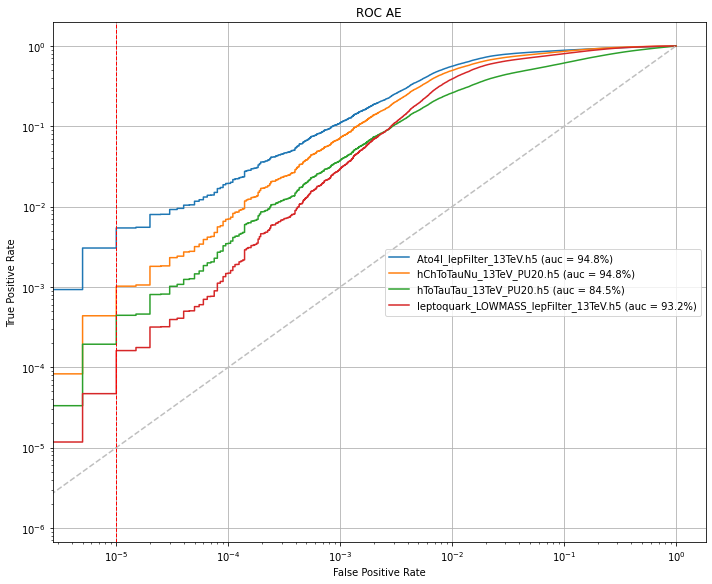

In [180]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    
    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(signals_files[i],auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()

In [165]:
total_loss[0]

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(200000,), dtype=float64, numpy=
array([0.20043047, 0.2691875 , 0.06519824, ..., 1.96653947, 0.16231564,
       0.24942219])>>

In [ ]:
tpr_loss